In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='darkgrid')

from sklearn.feature_selection import RFECV, VarianceThreshold
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.preprocessing import OrdinalEncoder
#from ml-metrics import quadratic_weighted_kappa
random_state = 42

import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./feature-selection-notebook.ipynb
./Ready_FS.csv
./cazymes_PA_metadata.csv
./metadata.csv
./.ipynb_checkpoints/feature-selection-notebook-checkpoint.ipynb


In [3]:
train_df = pd.read_csv('cazymes_PA_metadata.csv')
train_df = train_df.drop(columns=["Assembly accession", "MAG", "Family", "Genus"])
train_df.head()

GT2_Glycos_transf_2  GT9  GT4  GT5  GT25  GH30_1  GH3  GH144  GT51  GH25  \
0                    1    1    1    1     0       0    1      0     1     0   
1                    1    1    1    1     0       0    1      0     1     0   
2                    1    1    1    1     0       0    1      0     1     0   
3                    1    1    1    1     0       1    1      1     1     0   
4                    1    0    1    1     0       1    1      0     1     0   

   ...  CBM77  CBM6+GH3  GH51+CBM35  GH18+CBM73  CBM32+PL7_5  PL7_5+4.2.2.3  \
0  ...      0         0           0           0            0              0   
1  ...      0         0           0           0            0              0   
2  ...      0         0           0           0            0              0   
3  ...      0         0           0           0            0              0   
4  ...      0         0           0           0            0              0   

   CBM47+PL7_3  CBM16+CBM47+PL7_3  CBM47+CBM6+CBM47+CBM6      Origin  
0            0                  0                      0  Non_marine  
1            0                  0                      0      Marine  
2            0                  0                      0      Marine  
3            0                  0                      0      Marine  
4            0                  0                      0  Non_marine  

[5 rows x 750 columns]

In [16]:
X_train, y_train = train_df.iloc[:, :-1], train_df.iloc[:, -1]
print(X_train.shape)
print(y_train.shape)

(1256, 749)
(1256,)


# 1. Unsupervised approach
Reference:
https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection****

In [5]:
X_train2_unsup  = X_train.copy() #deep copy

## Drop by the missing rate

In [6]:
#Suppose you data now contains some missing data, you want to filter the data with very high missing rate.
X_train2_unsup['dump'] = np.nan
X_train2_unsup2 = X_train2_unsup.dropna(axis=1, thresh=0.8) #drop the columns with missing rate > 80%
print(X_train2_unsup.shape)
print(X_train2_unsup2.shape) #drop the demp column

(1256, 750)
(1256, 749)


## Drop by the variance

In [7]:
selector = VarianceThreshold(0.1) #original: 0.7
selector.fit(X_train2_unsup2)
X_train2_unsup3 = X_train2_unsup2[X_train2_unsup2.columns[selector.get_support(indices=True)]]
print('number of columns after dropping by variance threshold:', X_train2_unsup3.shape[1])

number of columns after dropping by variance threshold: 92


# 2. supervised approach

In [8]:
X_train2_sup = X_train.copy() #deep copy

In [9]:
%%time
X_model, X_valid, y_model, y_valid = train_test_split(X_train2_sup, y_train, stratify=y_train, random_state=random_state, test_size=.8)

model_dict = {'LogisticRegression': LogisticRegression(penalty='l1', solver='saga', C=2, multi_class='multinomial', n_jobs=-1, random_state=random_state)
             , 'ExtraTreesClassifier': ExtraTreesClassifier(n_estimators=200, max_depth=3, min_samples_leaf=.06, n_jobs=-1, random_state=random_state)
              , 'RandomForestClassifier': RandomForestClassifier(n_estimators=20, max_depth=5, min_samples_leaf=.1, random_state=random_state, n_jobs=-1)
             }
estimator_dict = {}
importance_fatures_sorted_all = pd.DataFrame()
for model_name, model in model_dict.items():
    print('='*10, model_name, '='*10)
    model.fit(X_model, y_model)
    print('Accuracy in training:', accuracy_score(model.predict(X_model), y_model))
    print('Accuracy in valid:', accuracy_score(model.predict(X_valid), y_valid))
    importance_values = np.absolute(model.coef_) if model_name == 'LogisticRegression' else model.feature_importances_
    importance_fatures_sorted = pd.DataFrame(importance_values.reshape([-1, len(X_train2_sup.columns)]), columns=X_train2_sup.columns).mean(axis=0).sort_values(ascending=False).to_frame()
    importance_fatures_sorted.rename(columns={0: 'feature_importance'}, inplace=True)
    importance_fatures_sorted['ranking']= importance_fatures_sorted['feature_importance'].rank(ascending=False)
    importance_fatures_sorted['model'] = model_name
    print('Show top 10 important features:')
    display(importance_fatures_sorted.drop('model', axis=1).head(10))
    importance_fatures_sorted_all = importance_fatures_sorted_all.append(importance_fatures_sorted)
    estimator_dict[model_name] = model

plt.title('Feature importance ranked by number of features by model')
sns.lineplot(data=importance_fatures_sorted_all, x='ranking', y='feature_importance', hue='model')
plt.xlabel("Number of features selected")

========== LogisticRegression ==========
Accuracy in training: 0.9721115537848606
Accuracy in valid: 0.8248756218905473
Show top 10 important features:


/home/sandra/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


feature_importance  ranking
GH154                  0.993730      1.0
GT1                    0.931085      2.0
CBM6+GH81              0.864846      3.0
CBM48+GH13             0.841954      4.0
GT83                   0.772383      5.0
CBM47                  0.769294      6.0
GH5_2                  0.760716      7.0
CBM32+CBM32            0.693997      8.0
CBM9                   0.692009      9.0
GH0                    0.690138     10.0

========== ExtraTreesClassifier ==========
Accuracy in training: 0.7450199203187251
Accuracy in valid: 0.6965174129353234
Show top 10 important features:


feature_importance  ranking
GH25                  0.060353      1.0
GH13_20               0.049495      2.0
CE12                  0.038776      3.0
CE4                   0.035116      4.0
GH97                  0.033311      5.0
GH113                 0.031507      6.0
GT20                  0.029436      7.0
GT83                  0.028062      8.0
GH15                  0.027582      9.0
CE8+PL10_1            0.026900     10.0

========== RandomForestClassifier ==========
Accuracy in training: 0.7091633466135459
Accuracy in valid: 0.6746268656716418
Show top 10 important features:


feature_importance  ranking
GT83                    0.129743      1.0
GH113                   0.111111      2.0
GH144                   0.087385      3.0
GH74                    0.080082      4.0
GH30_3                  0.079004      5.0
CBM48+GH13_9            0.057937      6.0
GH109                   0.054866      7.0
GH67                    0.052636      8.0
GH25                    0.052427      9.0
GH97                    0.043845     10.0

CPU times: user 1.01 s, sys: 63.9 ms, total: 1.08 s
Wall time: 773 ms


Text(0.5, 0, 'Number of features selected')

In [10]:
selected_model = 'LogisticRegression'
number_of_features = 60
select_features_by_model = importance_fatures_sorted_all[importance_fatures_sorted_all['model'] == selected_model].index[:number_of_features].tolist()

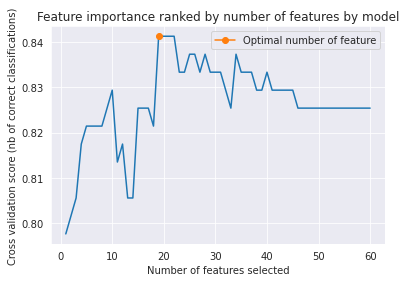

CPU times: user 2.18 s, sys: 88.8 ms, total: 2.27 s
Wall time: 4.58 s


In [11]:
%%time
#it takes much more time comparing 
rfecv = RFECV(estimator=model_dict['LogisticRegression'].set_params(max_iter=150, C=1), step=1, cv=StratifiedShuffleSplit(1, test_size=.2, random_state=random_state), scoring='accuracy', n_jobs=-1)
rfecv.fit(X_train2_sup[select_features_by_model], y_train)
plt.figure()
plt.title('Feature importance ranked by number of features by model')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.plot(rfecv.n_features_, rfecv.grid_scores_[rfecv.n_features_-1], marker='o', label='Optimal number of feature')
plt.legend(loc='best')
plt.show()

In [12]:
rfecv_df = pd.DataFrame({'col': select_features_by_model})
rfecv_df['rank'] = np.nan
for index, support in enumerate(rfecv.get_support(indices=True)):
    rfecv_df.loc[support, 'rank'] = index
for index, rank in enumerate(rfecv.ranking_ -2):
    if rank >= 0:
        rfecv_df.loc[index, 'rank'] = rfecv.n_features_ + rank
rfecv_df

col  rank
0                    GH154   0.0
1                      GT1   1.0
2                CBM6+GH81   2.0
3               CBM48+GH13   3.0
4                     GT83  30.0
5                    CBM47  25.0
6                    GH5_2  37.0
7              CBM32+CBM32   4.0
8                     CBM9  20.0
9                      GH0  45.0
10                    GT20  33.0
11             GT0+GT2+GT4   5.0
12                 GH13_20   6.0
13                   GH133   7.0
14                 GH43_29  49.0
15                   GH113   8.0
16                    GH89  27.0
17                    GH18  54.0
18                   GH109   9.0
19               CBM57+GH2  44.0
20                    GH25  10.0
21              CBM50+GH73  22.0
22                   GH144  36.0
23                    GH32  29.0
24  CBM13+CBM32+CBM57+CBM6  11.0
25                    GT19  41.0
26             CBM35+PL9_1  12.0
27                 GH43_18  19.0
28              GH23+CBM50  57.0
29                    GT11  59.0
30                 GH13_38  42.0
31                    GH26  24.0
32                  GH30_1  23.0
33                 GT0+GT4  31.0
34                  GH13_3  13.0
35                    GH95  53.0
36                    GH20  46.0
37                 GT2+GT9  14.0
38                   GH149  47.0
39                    GH74  21.0
40           GH18+3.2.1.14  55.0
41                     CE8  40.0
42                 CE1+CE6  50.0
43                    PL29  52.0
44               PL9+CBM22  15.0
45                   CBM13  48.0
46                   GH115  16.0
47                    PL37  28.0
48                   CBM38  17.0
49                     CE4  18.0
50                    GH11  51.0
51           GH43_34+CBM32  34.0
52                    GH24  26.0
53                    GH64  35.0
54                 GH43_10  32.0
55                    GH65  39.0
56                   GH127  56.0
57                    GH50  43.0
58                   AA3_2  38.0
59                  PL12_2  58.0

Automatically created module for IPython interactive environment
Optimal number of features : 134


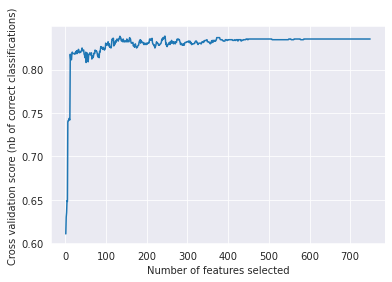

In [17]:
# Recursive feature elimination with cross-validation¶
# https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py
print(__doc__)

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy',
              min_features_to_select=min_features_to_select)
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()